In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from typing import Iterable
from tqdm import tqdm
from scipy.integrate import  quadrature,quad,trapezoid,nquad,romb
# from scipy.integrate import inte
import numpy as np
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from wolframclient.serializers import export
from wolframclient.deserializers import binary_deserialize
import networkx as nx
from numpy import sqrt

In [2]:
torch.randn_like(torch.complex(torch.tensor(0.),torch.tensor(0.)))

tensor(0.8116-0.2942j)

(<Axes: >, tensor(5.9286e-06))

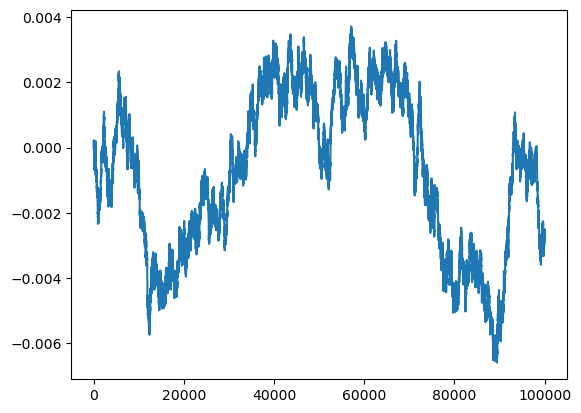

In [51]:
A = torch.complex(torch.tensor(0.),torch.tensor(0.))
samples = []
dt = 1e-4
kappa=0.1
ys=1
yp=100
F = 1 * ( ys * np.sqrt(yp)/(4*kappa))

for i in range(100000):
    A += dt * (-ys/2*A + kappa * (2 / sqrt(yp)*F-kappa/yp*(A**2)) * A.conj() + 
               2*kappa/np.sqrt(yp)*A.conj()*torch.randn_like(A)/2 + 
               np.sqrt(ys)*torch.randn_like(A)/2)
    samples.append(A.detach().clone())
samples = torch.tensor(samples)
sns.lineplot(samples.real), torch.var(samples.real)

In [41]:
A**2, A.pow(2)

(tensor(0.0053+0.0015j), tensor(0.0053+0.0015j))

In [26]:
ys * np.sqrt(yp)/(4*kappa)

25.0

In [76]:
G = nx.erdos_renyi_graph(n=6, p=0.4)
while nx.is_connected(G) == False:
    G = nx.erdos_renyi_graph(n=6, p=0.4)
# G = nx.from_numpy_array(A.numpy())
# nx.draw(G, with_labels=True)
A = nx.to_numpy_array(G)
A.astype(str)
A = -torch.tensor(A)

In [154]:
print("{"+ ",\n".join(["{"+','.join(i.astype(str))+"}" for i in A.numpy()]) + "}")

{{-0.0,-1.0,-0.0,-0.0,-1.0,-1.0},
{-1.0,-0.0,-0.0,-1.0,-0.0,-0.0},
{-0.0,-0.0,-0.0,-0.0,-1.0,-0.0},
{-0.0,-1.0,-0.0,-0.0,-1.0,-0.0},
{-1.0,-0.0,-1.0,-1.0,-0.0,-0.0},
{-1.0,-0.0,-0.0,-0.0,-0.0,-0.0}}


In [50]:
def V(x):
    return x.T.matmul(A).matmul(x)
from tqdm import tqdm
def monte_carlo_integration_mh(domain, samples, burn_in,  func, stepsize):
    function_sum = 0
    dvals = torch.tensor(domain).double()
    dist = torch.distributions.Uniform(0,1)
    lower = dvals[:,0]
    upper = dvals[:,1]
    print(lower, upper)
    def mh_filter(old_value, new_value):
        rngval = np.log(dist.sample())
        diff = -(new_value-old_value)
        # print(diff, rngval, rngval < diff)
        return rngval < diff
    proposal = torch.distributions.MultivariateNormal(loc=torch.zeros(len(dvals)).double(),
                                                      covariance_matrix=stepsize**2*torch.eye(len(dvals)).double())
    nlogged = 0
    x = proposal.sample()
    current_fval = func(x)
    for i in tqdm(range(burn_in), disable=True):
        y = (x + proposal.sample()).clamp(lower, upper)
        newfval = func(y)
        if mh_filter(current_fval, newfval):
            x = y.clone().detach()
    total = 0
    while nlogged < samples:
        y = (x + proposal.sample()).clamp(lower, upper)
        newfval = func(y)
        if mh_filter(current_fval, newfval):
            x = y.clone().detach()

            function_sum += torch.exp(-newfval)
            nlogged+=1
        total += 1
    volume = np.prod([i[1]-i[0] for i in dvals])
    return function_sum * volume / samples

def monte_carlo_integration(domain, samples, burn_in,  func, stepsize):
    function_sum = 0
    dvals = torch.tensor(domain).double()
    dist = torch.distributions.Uniform(0,1)
    lower = dvals[:,0]
    upper = dvals[:,1]
    
    total = 0
    dist = torch.distributions.Uniform(low=lower, high=upper)
    npoints = dist.sample((samples,))
    for sample in tqdm(npoints):
        fval = func(sample)
        function_sum += torch.exp(-fval)
        total += 1
    volume = np.prod([i[1]-i[0] for i in dvals])
    return function_sum * volume / samples

In [61]:
J = torch.tensor([[ 0.        , -0.0747298 ,  0.35115271, -0.05824643, -0.03770921,
        -0.09932179],
       [-0.0747298 ,  0.        ,  0.27704783, -0.0312771 ,  0.13704879,
        -0.17911163],
       [ 0.35115271,  0.27704783,  0.        ,  0.78992806,  0.59648707,
        -0.45146381],
       [-0.05824643, -0.0312771 ,  0.78992806,  0.        ,  0.27594456,
         0.23912909],
       [-0.03770921,  0.13704879,  0.59648707,  0.27594456,  0.        ,
         0.08309336],
       [-0.09932179, -0.17911163, -0.45146381,  0.23912909,  0.08309336,
         0.        ]]).double()
dim = 5
J = (torch.rand((dim, dim))*2 - 1).double()
J = (J + J.T)/2
h  = torch.rand((dim,))*2 - 1
def func(x):
    return -0.5*x.matmul(J.matmul(x)) - (h.dot(x))

In [62]:

Z = monte_carlo_integration([[-1,1]]*dim, samples=4000000, burn_in=1000, func=func, stepsize=0.01)
Z

100%|██████████| 4000000/4000000 [00:18<00:00, 213036.37it/s]


tensor(2.1982e+09, dtype=torch.float64)

In [63]:
Zdesc = 0
points = [[-1.,1.]]*dim

for i in product(*points):
    x = torch.tensor(i).double()
    Zdesc += torch.exp(-func(x))
s1 = 0
s2 = 0
kl_divergence = 0
for i in product(*points):
    x = torch.tensor(i).double()
    bounds = [(min(0, x[j]), max(0, x[j])) for j in range(x.shape[0])]
    p1 = monte_carlo_integration(bounds, samples=1000000, burn_in=3000, func=func, stepsize=0.01) / Z
    p2 = torch.exp(-func(x)) / Zdesc
    s1 += p1
    s2 += p2
    kl_divergence += p1 * np.log(p1/p2)
    print(p1.item(), p2.item())


100%|██████████| 4000000/4000000 [00:18<00:00, 212425.55it/s]


3.1816783336443972e-09 1.9665963823659795e-14


100%|██████████| 4000000/4000000 [00:18<00:00, 212030.77it/s]


2.444429977393851e-07 1.7408333745389982e-14


100%|██████████| 4000000/4000000 [00:18<00:00, 213180.08it/s]


7.76549305454354e-07 4.472057978938755e-15


100%|██████████| 4000000/4000000 [00:18<00:00, 211758.88it/s]


0.567460949823087 0.499999976188349


100%|██████████| 4000000/4000000 [00:18<00:00, 213408.14it/s]


1.221278987727178e-07 1.6419486712498557e-12


100%|██████████| 4000000/4000000 [00:18<00:00, 213141.30it/s]


2.6334106341497433e-10 1.5620586944563443e-21


100%|██████████| 4000000/4000000 [00:18<00:00, 212393.73it/s]


4.2739615532538095e-08 1.5847630946705284e-13


100%|██████████| 4000000/4000000 [00:18<00:00, 216318.86it/s]


4.8770685651939876e-05 1.904244504119169e-08


100%|██████████| 4000000/4000000 [00:18<00:00, 212415.97it/s]


8.437821544783416e-09 5.590605578004944e-16


100%|██████████| 4000000/4000000 [00:18<00:00, 213880.34it/s]


4.1058200385382177e-10 9.234842850365528e-21


100%|██████████| 4000000/4000000 [00:18<00:00, 214730.75it/s]


6.167885749357059e-10 1.9113580941968196e-21


100%|██████████| 4000000/4000000 [00:18<00:00, 215395.66it/s]


1.2822695416731658e-05 3.987799420563839e-12


100%|██████████| 4000000/4000000 [00:18<00:00, 214429.68it/s]


3.884229164531448e-05 4.763353100318019e-09


100%|██████████| 4000000/4000000 [00:18<00:00, 214246.55it/s]


2.565932235533859e-10 8.456277687073741e-23


100%|██████████| 4000000/4000000 [00:18<00:00, 215699.31it/s]


7.32118129102552e-09 6.9120769722764655e-15


100%|██████████| 4000000/4000000 [00:18<00:00, 214082.83it/s]


4.091012794027874e-08 1.5498712252847072e-14


100%|██████████| 4000000/4000000 [00:18<00:00, 217481.19it/s]


4.1733558307620185e-08 1.5498712252847072e-14


100%|██████████| 4000000/4000000 [00:18<00:00, 216776.96it/s]


7.347148403820066e-09 6.9120769722764655e-15


100%|██████████| 4000000/4000000 [00:18<00:00, 216883.47it/s]


2.5834998154799046e-10 8.456277687073741e-23


100%|██████████| 4000000/4000000 [00:18<00:00, 215174.18it/s]


3.870023091671802e-05 4.763353100318019e-09


100%|██████████| 4000000/4000000 [00:18<00:00, 216984.52it/s]


1.2973992764696772e-05 3.987799420563839e-12


100%|██████████| 4000000/4000000 [00:18<00:00, 212574.00it/s]


6.14931332826649e-10 1.9113580941968196e-21


100%|██████████| 4000000/4000000 [00:18<00:00, 214486.24it/s]


4.068197847926281e-10 9.234842850365528e-21


100%|██████████| 4000000/4000000 [00:18<00:00, 212800.59it/s]


8.464853538156655e-09 5.590605578004944e-16


100%|██████████| 4000000/4000000 [00:18<00:00, 212835.49it/s]


4.9529921043321364e-05 1.904244504119169e-08


100%|██████████| 4000000/4000000 [00:18<00:00, 214021.38it/s]


4.245595890440365e-08 1.5847630946705284e-13


100%|██████████| 4000000/4000000 [00:18<00:00, 212798.61it/s]


2.636250455664745e-10 1.5620586944563443e-21


100%|██████████| 4000000/4000000 [00:18<00:00, 214440.56it/s]


1.218615225812041e-07 1.6419486712498557e-12


100%|██████████| 4000000/4000000 [00:18<00:00, 214429.13it/s]


0.5074713921997639 0.499999976188349


100%|██████████| 4000000/4000000 [00:18<00:00, 214401.30it/s]


7.661089232255251e-07 4.472057978938755e-15


100%|██████████| 4000000/4000000 [00:18<00:00, 215020.71it/s]


2.3954095559506294e-07 1.7408333745389982e-14


100%|██████████| 4000000/4000000 [00:19<00:00, 209877.52it/s]

3.166616768543963e-09 1.9665963823659795e-14


In [60]:
s1, s2, kl_divergence

(tensor(1.0030, dtype=torch.float64),
 tensor(1., dtype=torch.float64),
 tensor(0.2826, dtype=torch.float64))

In [69]:

p1 = monte_carlo_integration([[-1,0], [0,1]], samples=100000, burn_in=3000, func=func, stepsize=0.01) / Z
p1

100%|██████████| 3000/3000 [00:00<00:00, 38283.05it/s]


tensor(0.2541, dtype=torch.float64)

-60.195148246065116


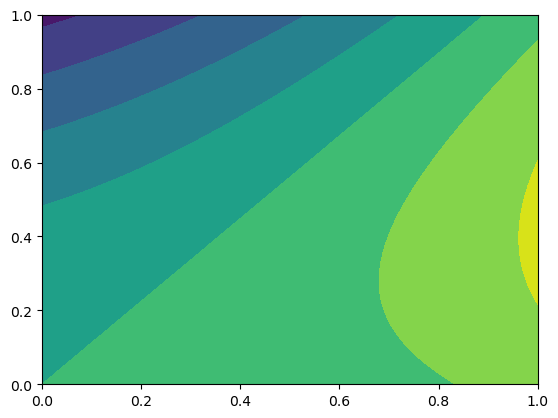

In [72]:
def npf(x,y):
    z = torch.tensor([x,y]).double()
    return -0.5*z.matmul(J.matmul(z))
npf = np.vectorize(npf)
x, y = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = npf(X, Y)
print(np.sum(Z))
plt.contourf(X, Y, Z)

In [153]:

monte_carlo_integration(domain=[[-1, 1]] * 6,
                        samples=200000,
                        burn_in=1000,
                        stepsize=1,
                        func=V)

0.4065875311801813


/tmp/ipykernel_13216/3382351310.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  monte_carlo_integration(domain=[[-1, 1]] * 6,


tensor(27.6591, dtype=torch.float64)

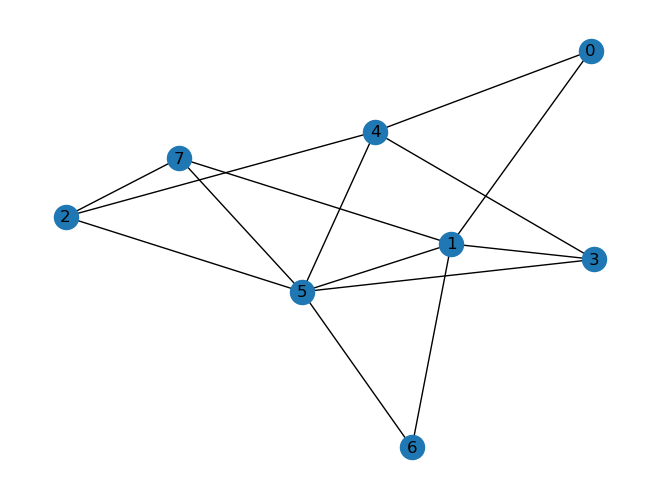

In [208]:

print(A == A.T)

# vals = torch.rand(3)
# vals.requires_grad_(True)
# value = V(vals)
# value.backward()
# value, vals.grad

tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]])
